# DAVI End-Semester Assignment - COE Analysis

## Objectives:

1.  Find factors of which influence COE premium
2.  Find correlation among the factors

## Import Dependencies

In [1]:
# Data Manipulation
import math                         # Ceiling Method
import numpy as np                  # Function Vectorization, Data Type, Quick Array Creation
import pandas as pd                 # Data Reshaping
import statsmodels.api as sm        # Linear Regression Model

# Graphing
import matplotlib.pyplot as plt     # Exporting Plots to Raster Images
import seaborn as sns               # Plotting Module
import plotly.express as px         # More Advanced Plotting Module

%matplotlib inline

In [2]:
# To Export plotly.express Graphs
# will be different for every local machine
import os
os.environ['PATH'] += ';C:/Users/ethanol/AppData/Local/Programs/Python/Python38-32/Lib/site-packages/kaleido/executable'

## Preparation

### Set Default Theme

In [3]:
sns.set_theme(rc={'figure.figsize': (10, 6)}, palette='Set1')

### Load Dataset (from PDAS)

In [4]:
df = pd.read_csv('./data/clean.csv', index_col=0)
print(df.dtypes, df.count(), df.describe().round(2), df.head(), sep='\n\n')

Date                      object
Bidding Session            int64
Category                  object
Quota                      int64
Successful Bids            int64
Received Bids              int64
Premium                    int64
PQP                        int64
Population                 int64
Number of Registered       int64
Number of Deregistered     int64
Year                       int64
Month                      int64
Quarter                    int64
dtype: object

Date                      400
Bidding Session           400
Category                  400
Quota                     400
Successful Bids           400
Received Bids             400
Premium                   400
PQP                       400
Population                400
Number of Registered      400
Number of Deregistered    400
Year                      400
Month                     400
Quarter                   400
dtype: int64

       Bidding Session    Quota  Successful Bids  Received Bids   Premium  \
count       

### Dataset Alterations

In [5]:
personal_cars_mask = df['Category'].str.contains(r'[AB]')
exclude_2018_mask = df['Year'] != 2018

df_personal_cars = df[personal_cars_mask]
df_exclude_2018 = df[exclude_2018_mask]

### Utility Functions

In [6]:
def shorten(num: int) -> str:
    '''
    Shorten large numbers, using a suffix to replace trailing zeroes 
    '''
    return str(round(num / 1000)) + 'k'

shortenVect = np.vectorize(shorten)

def convertDateTicks(i: int, monthOnly: bool = False, quarterOnly: bool = False, yearOnly: bool = False, base_Y: int = 2014, base_m: int = 1) -> str:
    '''
    Convert default tick values to dates (string format)
    '''
    month = int(i % 12) + base_m
    quarter = math.ceil(month / 3)
    year = int(i / 12 if month == 1 else (i - (i % 12)) / 12) + base_Y
    if monthOnly:
        return str(month)
    if quarterOnly:
        return str(quarter)
    if yearOnly:
        return str(year)
    return f'{month}/{year}'

convertDateTicksVect = np.vectorize(convertDateTicks)

def maskDate(i: int, how: str = 'Y') -> str:
    if how == 'Y':
        return convertDateTicks(i=i, yearOnly=True) if convertDateTicks(i=i, monthOnly=True) == '1' else ''
    if how == 'q':
        return convertDateTicks(i=i, quarterOnly=True) if (int(convertDateTicks(i=i, monthOnly=True)) - 1) % 4 == 0 else ''
    if how == 'm':
        return convertDateTicks(i=i, monthOnly=True)
    return ''

maskDateVect = np.vectorize(maskDate)

def verboseMonth(i: int, zeroIndex: bool = False, full: bool = False) -> str:
    return (['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] if not full else ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])[int(i if zeroIndex else i - 1)]

verboseMonthVect = np.vectorize(verboseMonth)

## Analysis

### Factor 1:   Vehicle Category

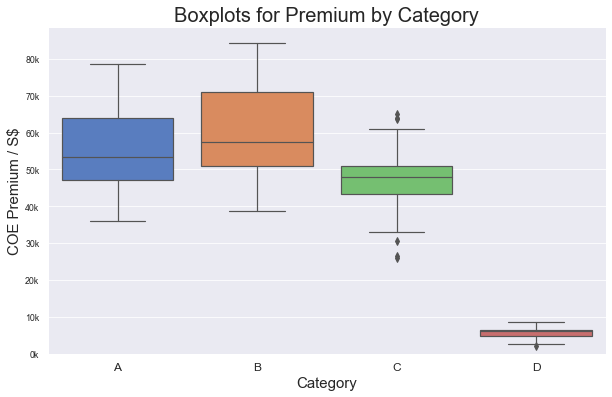

In [7]:
with sns.axes_style(style='darkgrid'):
    with sns.plotting_context(context='paper'):
        with sns.color_palette(palette='muted'):
            ax1 = sns.boxplot(data=df, x='Category', y='Premium')
            ax1.set_title(label='Boxplots for Premium by Category', fontdict=dict(size=20))
            ax1.set_xlabel(xlabel='Category', fontdict=dict(size=15))
            ax1.set_xticklabels(labels=['A', 'B', 'C', 'D'], fontdict=dict(size=12))
            ax1.set_ylabel(ylabel='COE Premium / S$', fontdict=dict(size=15))
            ax1.set_ylim(bottom=0)
            ax1.set_yticklabels(labels=shortenVect(ax1.get_yticks()))
            plt.savefig('./assets/boxplots-premium-by-category.png')

Category is the most defining factor when it comes to COE pricing, with Categories A and B topping the charts.

We can’t comment too much on Category C, since it is reserved for corporate purposes.

Since Category D is for motorcycles, the premium for Category D is obviously always the lowest.

To provide better context, these are the definitions of the above categories:

+   A)  Internal Combustion Engine (ICE) cars with an engine capacity of at most 1600cc and Electric cars with engine power of at most 97kW
+   B)  Internal Combustion Engine (ICE) cars with an engine capacity of at least 1600cc and Electric cars with engine power of at least 97kW
+   C)  Goods Vehicles (like trucks, lorries) and Buses
+   D)  Motorcycles

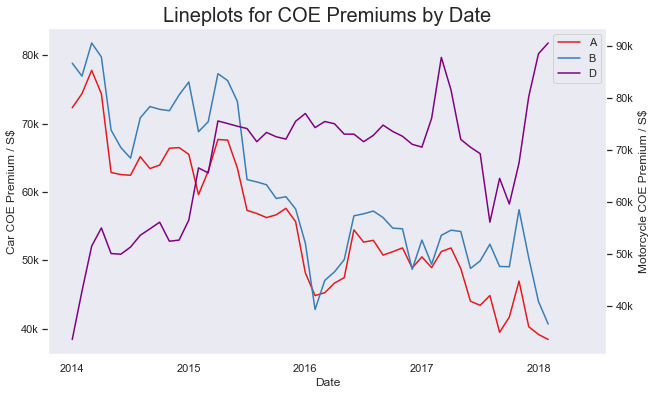

In [8]:
with sns.axes_style('darkgrid', {'axes.grid': False}):
    ax2 = sns.lineplot(data=df_personal_cars, x='Date', y='Premium', hue='Category', ci=None)
    ax2.set_ylabel(ylabel='Car COE Premium / S$')
    ax2.set_xlim(right=55)
    ax2_twin = ax2.twinx()
    ax2_twin.set_ylabel(ylabel='Motorcycle COE Premium / S$')
    sns.lineplot(data=df[df['Category'] == 'D'], x='Date', y='Premium', color='purple', ci=None, ax=ax2_twin)
    ax2.plot(np.nan, ls='-', color='purple', label = 'D')
    ax2.legend()
    ax2.set_title(label='Lineplots for COE Premiums by Date', fontsize=20)
    ax2.set_xticklabels(labels=maskDateVect(ax2.get_xticks()))
    ax2.set_yticklabels(labels=shortenVect(ax2.get_yticks()))
    ax2_twin.set_yticklabels(labels=shortenVect(ax2.get_yticks()))
    plt.savefig('./assets/lineplots-premium-by-date-and-category.png')

It is worth noting that there is a disparity between car COEs and motorcycles’, and that the motor vehicle landscape is shifting in favour of car owners.

First, the proportion of COE in comparison to the vehicle’s base price is absurd. Motorcycle COEs can be higher than the motorcycle models themselves, whereas car COEs are rarely, if not never, more expensive than the cars themselves.

Second, COE premiums for cars are going down whereas that for motorcycles is on the incline.

There is much more to this phenomenon, but it is outside the scope of this analysis.

Going forward, Categories C and D will be excluded from the analyses.

### Factor 2:   Quota

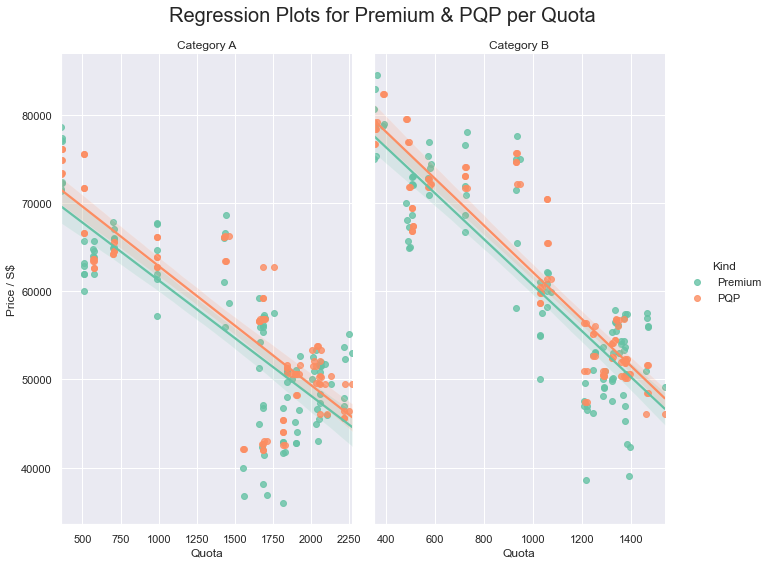

In [9]:
with sns.color_palette('Set2'):
    g1 = sns.FacetGrid(data=df_personal_cars.melt(id_vars=['Category', 'Quota'], value_vars=['Premium', 'PQP'], var_name='Kind', value_name='Price'), col='Category', hue='Kind', height=8, aspect=0.6, sharex=False)
    g1.map_dataframe(sns.regplot, x='Quota', y='Price')
    g1.set_xlabels('Quota')
    g1.set_ylabels('Price / S$')
    g1.set_titles(template='Category {col_name}')
    g1.add_legend()
    g1.fig.suptitle(t='Regression Plots for Premium & PQP per Quota', fontsize=20)
    g1.tight_layout()
    g1.savefig('./assets/regplots-premium-and-pqp-per-quota-by-category.png')

As COE quota increases, both the COE premium and Prevailing Quota Premium (PQP) increase.

This can be explained with basic economics.

In summary, value (of any arbitrary product/service):

-   decreases with supply for a fixed demand
-   increases with demand for a fixed supply

This is an oversimplified elaboration.

Since it’s a bidding system, higher quota means less competition for COEs. Bids will thus be less aggressive. This will lead to a reduced lowest reserve bid.

Therefore, premium is quite strongly negatively correlated to quota.

### Factor 3:   Bidding Session

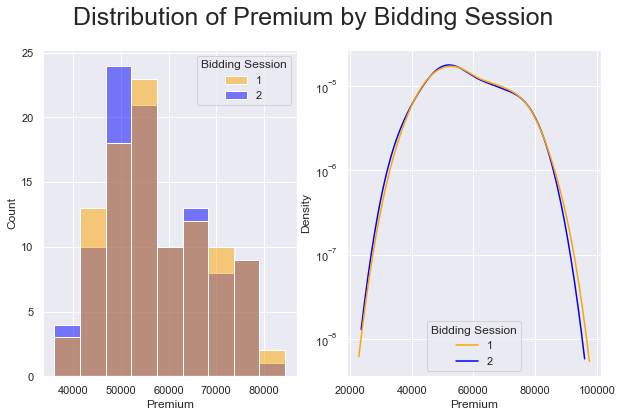

In [10]:
fig1, (ax3, ax4) = plt.subplots(nrows=1, ncols=2)
sns.histplot(data=df_personal_cars, x='Premium', hue='Bidding Session', fill=True, palette=['orange', 'blue'], ax=ax3)
sns.kdeplot(data=df_personal_cars, x='Premium', hue='Bidding Session', palette=['orange', 'blue'], ax=ax4)
ax4.set_yscale('log')
ax3.set_title(None)
ax4.set_title(None)
fig1.suptitle(t='Distribution of Premium by Bidding Session', fontsize=25)
fig1.savefig('./assets/hist-and-kde-premium-by-session.png')

This is an interesting one.

When charting the distribution of COE premiums by bidding session from a broad perspective, there seems to be little to no difference in COE premium.

COE premium appears to be about the same regardless of whether it was purchased in the beginning or the middle of the month.

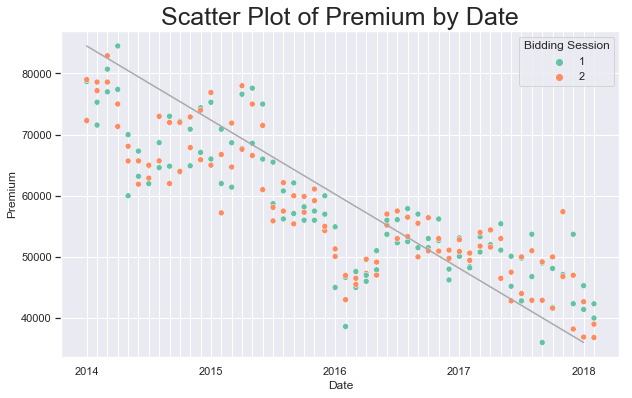

In [11]:
ax5 = sns.scatterplot(data=df_personal_cars, x='Date', y='Premium', hue='Bidding Session', palette='Set2')
c, m = sm.OLS.from_formula(formula='Premium ~ Quarter', data=df_personal_cars).fit().params
ax5_twin = ax5.twinx()
sns.lineplot(x=np.arange(5) * 12, y=(np.arange(5) + 2014) * m + c, color='darkgrey', ax=ax5_twin)
ax5_twin.set(yticks=[])
ax5.set_xticklabels(labels=maskDateVect(ax5.get_xticks()))
ax5.set_title('Scatter Plot of Premium by Date', fontsize=25)
plt.savefig('./assets/scatterplot-premium-by-date-and-session.png')

In addition, variations and residuals appear random and roughly equally distributed.
Nonetheless, a month-wise comparison yields different results...

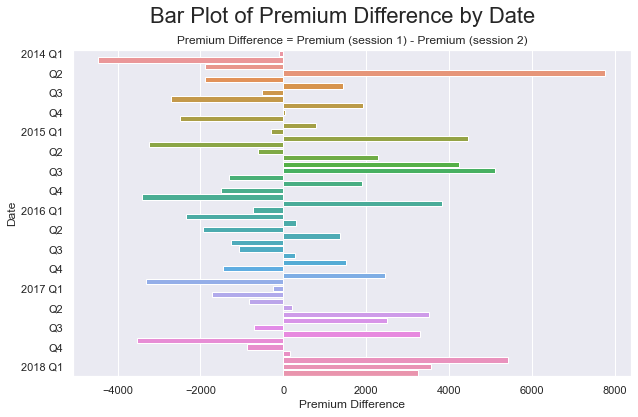

In [12]:
tmp1 = df_personal_cars.pivot_table(index='Date', columns='Bidding Session', values='Premium')
diff = (tmp1[1] - tmp1[2]).to_frame('Premium Difference').reset_index()
diff['Date'] = diff['Date'].apply(lambda x: pd.to_datetime(x, format='%Y-%m'))
diff.sort_values('Date', inplace=True)
ax6 = sns.barplot(data=diff, x='Premium Difference', y='Date')
ax6.set_yticks(ax6.get_yticks()[ax6.get_yticks() % 3 == 0])
plt.suptitle(t='Bar Plot of Premium Difference by Date', fontsize=22)
ax6.set_title('Premium Difference = Premium (session 1) - Premium (session 2)', fontsize=12)
ax6.set_yticklabels([(f'{convertDateTicks(i=i, yearOnly=True)} ' if i % 12 == 0 else '') + f'Q{convertDateTicks(i=i, quarterOnly=True)}' for i in ax6.get_yticks()])
plt.savefig('./assets/barplot-diff-by-date.png')

Premium differences do not seem so evenly distributed when graphed month-wise.

It would be easier to compare the two sessions using a histogram or boxplot.

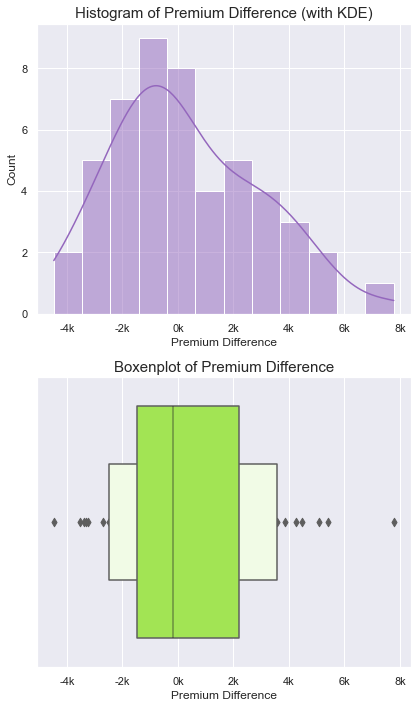

In [13]:
fig2, (ax7, ax8) = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))
sns.histplot(data=diff, x='Premium Difference', kde=True, bins=12, color='tab:purple', ax=ax7)
ax7.set_title('Histogram of Premium Difference (with KDE)', fontsize=15)
sns.boxenplot(data=diff, x='Premium Difference', palette='turbo', ax=ax8)
ax8.set_title('Boxenplot of Premium Difference', fontsize=15)
fig2.tight_layout()
ax7.set_xticklabels(labels=shortenVect(ax7.get_xticks()))
ax8.set_xticklabels(labels=shortenVect(ax8.get_xticks()))
fig2.savefig('./assets/hist-and-boxenplot-diff.png')

The distribution of premium differences (session 1 - session 2 of the same month) is positively skewed with a mean of roughly -$1000. There is thus a significant difference in COE premium between the two sessions.

The differences can be summarised in the following table:

|   Session     |   Variability     |   Tendency    |
|---------------|-------------------|---------------|
|   1           |   Greater         |   Lower       |
|   2           |   Lower           |   Higher      |

More often than not, the resulting bid value of the 2<sup>nd</sup> bidding session is higher than that of the corresponding 1<sup>st</sup>.

Nonetheless, the 1<sup>st</sup> bidding session may occasionally produce a much higher COE bid price than its 2<sup>nd</sup> session counterpart.

Therefore, this is a difficult factor.

As generalised by the concept “High risk, high reward”, session 1 would usually grant a S$1000 discount, but is subject to preposterous peaks occasionally.

### Correlation 1:  Quota ~ Bidding Session

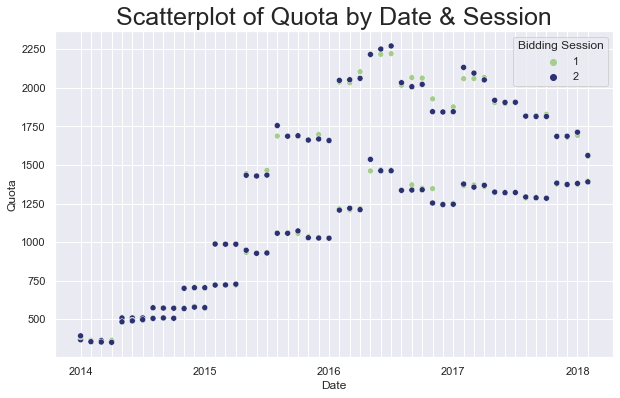

In [14]:
fig3 = px.scatter(data_frame=df_personal_cars, x='Date', y='Quota', color='Bidding Session', color_continuous_scale='tropic', title='Scatterplot of Quota by Date & Session')
fig3.write_image('./assets/scatterplot-quota-by-date-and-session.png', engine='kaleido')
ax9 = sns.scatterplot(data=df_personal_cars, x='Date', y='Quota', hue='Bidding Session', palette='crest')
ax9.set_title('Scatterplot of Quota by Date & Session', fontsize=25)
ax9.set_xticklabels(labels=maskDateVect(ax9.get_xticks()))
fig3

There is not much difference between COE quotas for bidding sessions 1 and 2, even though the premium varies.

### Correlation 2:  Quota ~ Year

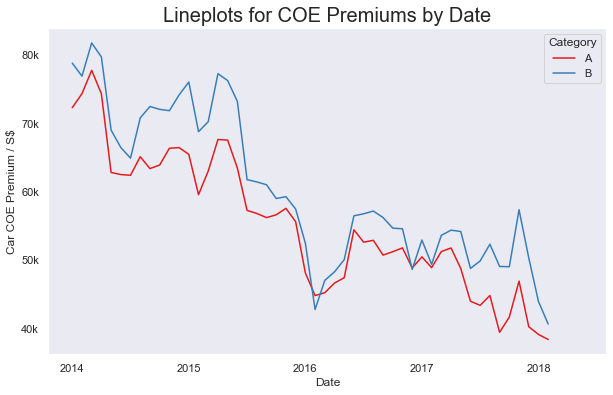

In [15]:
with sns.axes_style('darkgrid', {'axes.grid': False}):
    ax10 = sns.lineplot(data=df_personal_cars, x='Date', y='Premium', hue='Category', ci=None)
    ax10.set_ylabel(ylabel='Car COE Premium / S$')
    ax10.set_xlim(right=55)
    ax10.set_title(label='Lineplots for COE Premiums by Date', fontsize=20)
    ax10.set_xticklabels(labels=maskDateVect(ax10.get_xticks()))
    ax10.set_yticklabels(labels=shortenVect(ax10.get_yticks()))
    plt.savefig('./assets/lineplots-premium-by-date-and-category-ii.png')

Earlier, we mentioned that car COE premiums are on the decline.

It is possible that this observation can be explained by COE bidders are becoming more passive.

However, correlation does not always imply causation.

Perhaps it might be better explained by another factor behind the scenes...

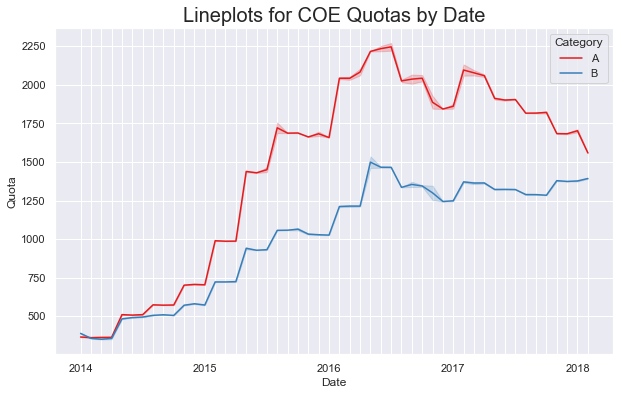

In [16]:
ax11 = sns.lineplot(data=df_personal_cars, x='Date', y='Quota', hue='Category')
ax11.set_ylabel(ylabel='Quota')
ax11.set_title(label='Lineplots for COE Quotas by Date', fontsize=20)
ax11.set_xticklabels(labels=maskDateVect(ax11.get_xticks()))
plt.savefig('./assets/lineplots-quota-by-date-and-category.png')

COE Quotas have been increasing.

As we mentioned earlier, premium decreases with quota.

Hence, this might be a better explanation for why COE premiums for both Category A and B vehicles have been decreasing, rather than the shift in bidders’ attitudes.

### Correlation 3:  Quota ~ Deregistered

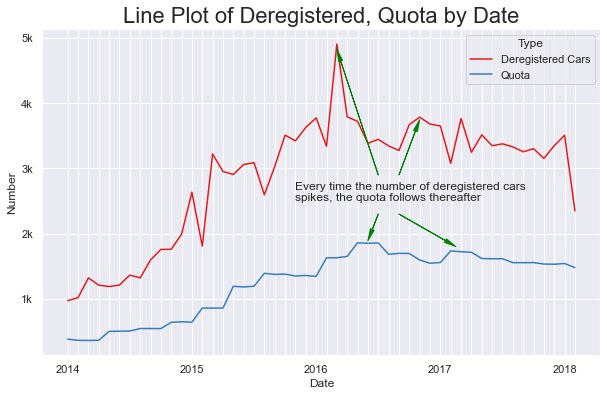

In [17]:
ax12 = sns.lineplot(data=df_personal_cars[['Date', 'Number of Deregistered', 'Quota']].melt(id_vars='Date', var_name='Type', value_name='Number'), x='Date', y='Number', hue='Type', ci=None)
ax12.set_xticklabels(labels=maskDateVect(ax12.get_xticks()))
ax12.annotate('Every time the number of deregistered cars\nspikes, the quota follows thereafter', xy=(22, 2500))
ax12.set_yticklabels(labels=shortenVect(ax12.get_yticks()))
ax12.set_ylabel(ylabel='Number')
ax12.annotate('', xy=(26, 4830), xytext=(30, 2900), arrowprops=dict(width=0.1, headwidth=4, color='green'), font=dict(size=12))
ax12.annotate('', xy=(37.5, 1800), xytext=(32, 2300), arrowprops=dict(width=0.1, headwidth=4, color='green'), font=dict(size=12))
ax12.annotate('', xy=(34, 3750), xytext=(32, 2900), arrowprops=dict(width=0.1, headwidth=4, color='green'), font=dict(size=12))
ax12.annotate('', xy=(29, 1890), xytext=(30, 2300), arrowprops=dict(width=0.1, headwidth=4, color='green'), font=dict(size=12))
ax12.legend(labels=('Deregistered Cars', 'Quota'), title='Type')
ax12.set_title(label='Line Plot of Deregistered, Quota by Date', fontsize=22)
plt.savefig('./assets/lineplots-deregistered-and-quota-by-date.png')

Notice how quota crests just after car deregistration peaks?

Quota is quite related to number of cars deregistered in the previous quarter.

The number of vehicles deregistered in the previous quarter of the year is actually one of the factors considered during the calculation of the supply of COEs.

### Correlation 4:  Deregistered ~ Month

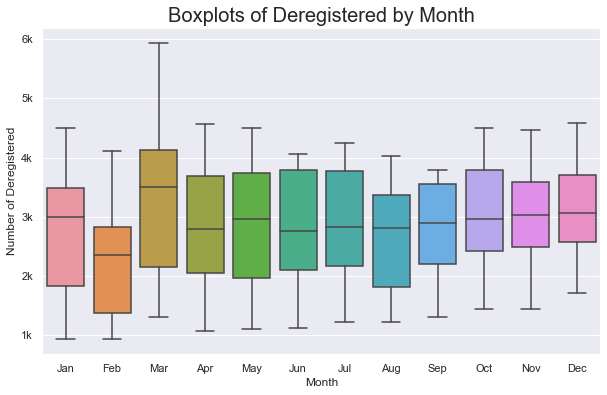

In [18]:
ax13 = sns.boxplot(data=df_personal_cars[exclude_2018_mask], x='Month', y='Number of Deregistered')
ax13.set_title(label='Boxplots of Deregistered by Month', fontsize=20)
ax13.set_xticklabels(labels=verboseMonthVect(i=ax13.get_xticks(), zeroIndex=True))
ax13.set_yticklabels(labels=shortenVect(num=ax13.get_yticks()))
plt.savefig('./assets/boxplots-deregistered-by-month.png')

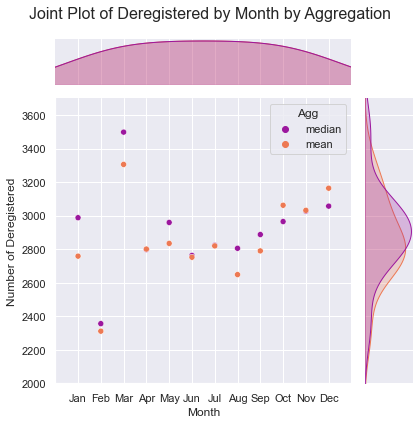

In [19]:
g2 = sns.jointplot(data=df_personal_cars[exclude_2018_mask].groupby(by='Month')['Number of Deregistered'].agg(['median', 'mean']).reset_index().melt(id_vars='Month', var_name='Agg', value_name='Number of Deregistered'), x='Month', y='Number of Deregistered', hue='Agg', palette='plasma', xlim=(0, 13), ylim=(2000, 3700))
g2.ax_joint.set_xticks(np.arange(1, 13))
g2.ax_joint.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
g2.fig.suptitle(t='Joint Plot of Deregistered by Month by Aggregation', fontsize=16)
g2.fig.tight_layout()
g2.savefig('./assets/jointplot-deregistered-by-month-and-agg.png')

Now let’s see if there’s a pattern in deregistration rates over the months.

March seems to have the greatest number of car deregistrations over the years.

But does this translate to higher quota automatically?

### Correlation 5:  Quota ~ Month

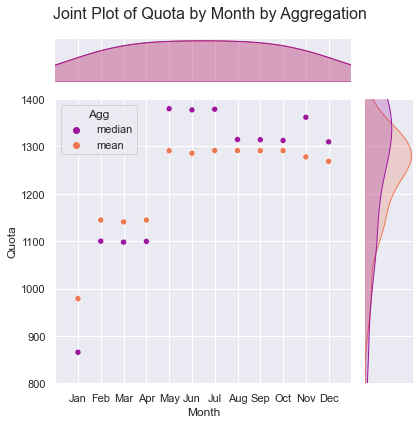

In [20]:
g3 = sns.jointplot(data=df_personal_cars[exclude_2018_mask].groupby(by='Month')['Quota'].agg(['median', 'mean']).reset_index().melt(id_vars='Month', var_name='Agg', value_name='Quota'), x='Month', y='Quota', hue='Agg', palette='plasma', xlim=(0, 13), ylim=(800, 1400))
g3.ax_joint.set_xticks(np.arange(1, 13))
g3.ax_joint.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
g3.fig.suptitle('Joint Plot of Quota by Month by Aggregation', fontsize=16)
g3.fig.tight_layout()
g3.savefig('./assets/jointplot-quota-by-month-and-agg.png')

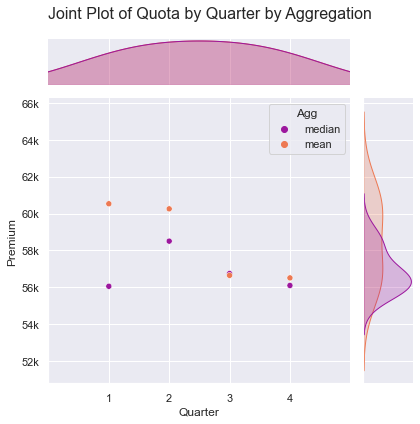

In [21]:
g4 = sns.jointplot(data=df_personal_cars[exclude_2018_mask].groupby(by='Quarter')['Premium'].agg(['median', 'mean']).reset_index().melt(id_vars='Quarter', var_name='Agg', value_name='Premium'), x='Quarter', y='Premium', hue='Agg', palette='plasma', xlim=(0, 5))
g4.ax_joint.set_xticks(ticks=np.arange(4) + 1)
g4.ax_joint.set_yticklabels(labels=shortenVect(g4.ax_joint.get_yticks()))
g4.fig.suptitle('Joint Plot of Quota by Quarter by Aggregation', fontsize=16)
g4.fig.tight_layout()
g4.savefig('./assets/jointplot-quota-by-quarter-and-agg.png')

No, number of cars deregistered cannot be used to solely explain quota trends.

In the preceding slide, we observed that March tends to have the greatest number of car deregistrations each year.

However, from the figure on the right, March does not have the greatest COE supply in the year. In fact, quota tends to increase toward the end of the year.

Well, then does this translate to premium?

### Correlation 6:  Premium ~ Month

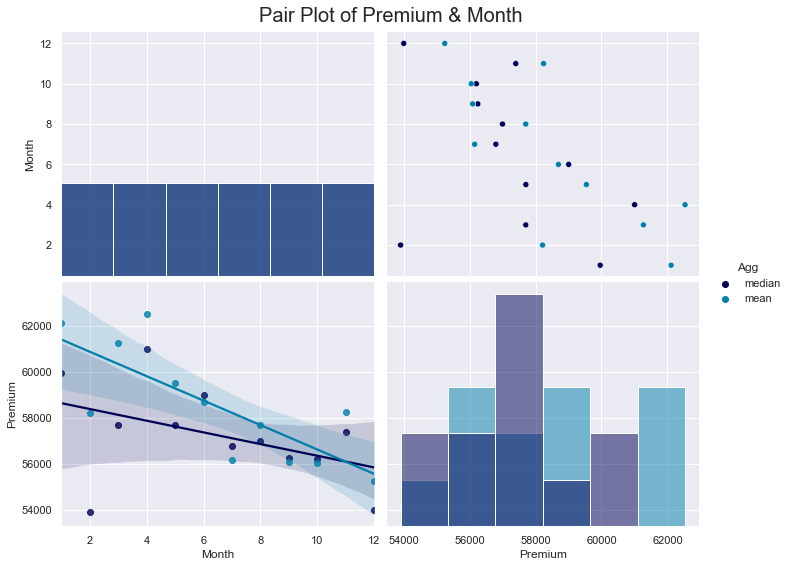

In [22]:
g5 = sns.PairGrid(data=df_personal_cars[exclude_2018_mask].groupby(by='Month')['Premium'].agg(['median', 'mean']).reset_index().melt(id_vars='Month', var_name='Agg', value_name='Premium'), hue='Agg', palette='ocean')
g5.fig.set_size_inches((10, 8))
g5.map_diag(sns.histplot)
g5.map_lower(sns.regplot)
g5.map_upper(sns.scatterplot)
g5.add_legend()
g5.fig.suptitle(t='Pair Plot of Premium & Month', fontsize=20)
g5.tight_layout()
g5.savefig('./assets/pairgrid-premium-month.png')
g5

Surprisingly, yes.

It can be seen that COE premiums decrease toward the end of each year (general trend).

There is one anomaly though (red circle). February also seems to have generally low COE premiums too.

December is a pretty good bet nonetheless.

### Correlation 7:  Quota, Successful Bids, Received Bids

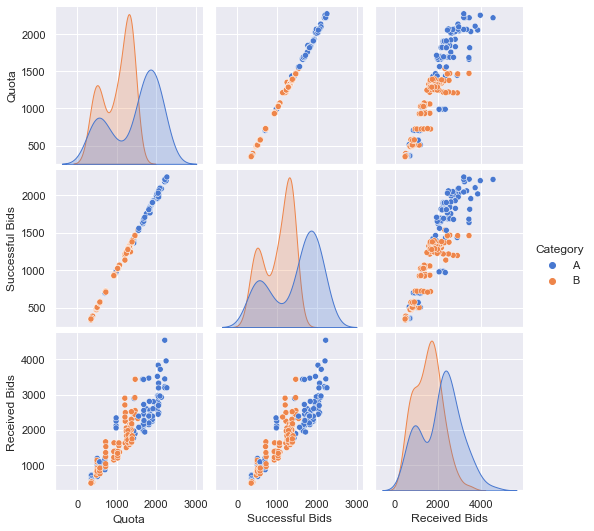

In [23]:
g6 = sns.pairplot(data=df_personal_cars[['Quota', 'Successful Bids', 'Received Bids', 'Category']], diag_kind='kde', hue='Category', palette='muted')
g6.savefig('./assets/pairplot-quota-successfulbids-receivedbids-by-category.png')

Quota and number of successful bids have a strong linear positive correlation.

This is not surprising as the number of successful bids is at its corresponding quota.

Quota and number of bids received also share a strong positive correlation.

Car dealerships would regulate the number of bids they submit according to the COE quota.

Furthermore, Category A seems to have higher quotas consistently (as the blue cluster is above the orange one).

### Correlation 8:  Population, Registered, Deregistered

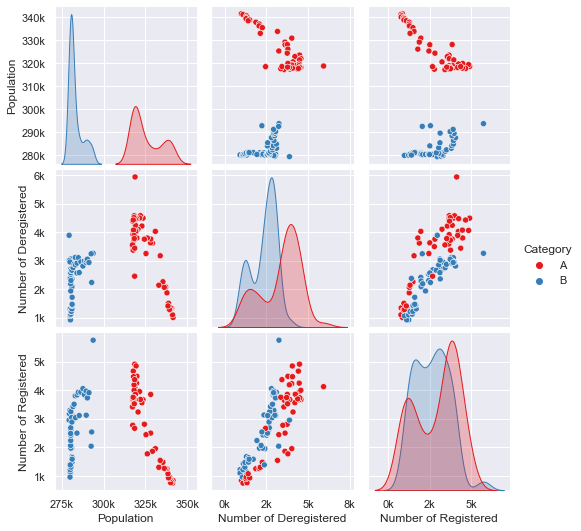

In [24]:
g7 = sns.pairplot(data=df_personal_cars[['Population', 'Number of Deregistered', 'Number of Registered', 'Category']], hue='Category')
for ax in g7.axes.flatten():
    ax.set_yticklabels(shortenVect(ax.get_yticks()))
    ax.set_xticklabels(shortenVect(ax.get_xticks()))
g7.savefig('./assets/pairplot-population-deregistered-registered-by-category.png')

There are more Category A cars registered in Singapore than Category B cars.

The number of cars registered is positively correlated to the number of cars deregistered.

The distribution of Category B cars registered is bimodal.

There is greater variation in population, number of cars registered and number of cars deregistered for Category A than Category B (histograms have wider bases).

### Final Correlations:     Trends over Time

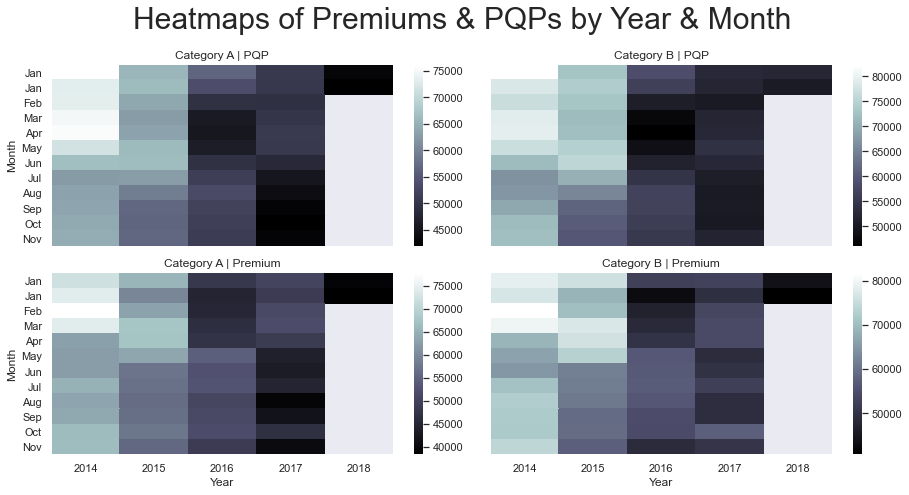

In [25]:
fig4, ((ax14, ax15), (ax16, ax17)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 7))
axes1 = (ax14, ax15, ax16, ax17)
cats = ('A', 'B')
types = ('Premium', 'PQP')
for i, f in enumerate(axes1):
    c = cats[int(i % 2 != 0)]
    t = types[int(i < 2)]
    sns.heatmap(data=df[df['Category'] == c].pivot_table(index='Month', columns='Year', values=t), cmap=sns.color_palette(palette='bone', as_cmap=True), ax=f)
    f.set_title(f'Category {c} | {t}')
    if i < 2:
        f.set_xticklabels(labels=[])
        f.set_xlabel(xlabel='')
    if i % 2 != 0:
        f.set_yticklabels(labels=[])
        f.set_ylabel(ylabel='')
    else:
        f.set_yticklabels(labels=verboseMonthVect(f.get_yticks()), rotation=0)
fig4.suptitle(t='Heatmaps of Premiums & PQPs by Year & Month', fontsize=30)
fig4.tight_layout()
fig4.savefig('./assets/heatmaps-premium-and-pqp-by-year-and-month.png')

PQP has been steadily decreasing over the past few years, with the exception of mid-2016.

COE premium, however, oscillates every 12 months (roughly). Following this pattern, if the year is odd, one should purchase a COE in the tail end of the year. Otherwise, one should purchase a COE early in the year.

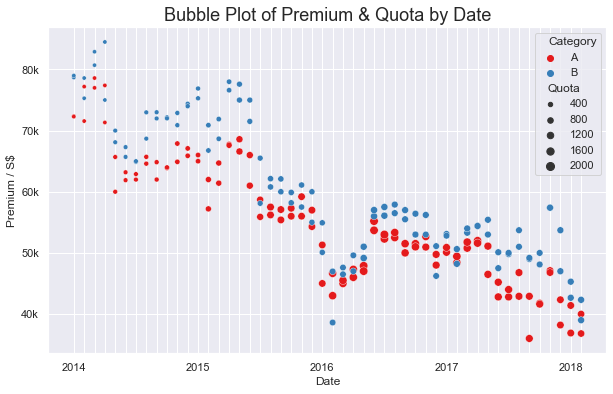

In [26]:
ax18 = sns.scatterplot(data=df_personal_cars, x='Date', y='Premium', size='Quota', hue='Category')
ax18.set_title(label='Bubble Plot of Premium & Quota by Date', fontsize=18)
ax18.set_yticklabels(labels=shortenVect(ax18.get_yticks()))
ax18.set_xticklabels(labels=maskDateVect(ax18.get_xticks()))
ax18.set_ylabel(ylabel='Premium / S$')
plt.savefig('./assets/bubbleplot-premium-and-quota-by-date.png')
fig5 = px.scatter(data_frame=df_personal_cars, x='Month', y='Premium', color='Category', size='Quota', animation_frame='Year', range_y=(30000, 90000), title='Bubble Plot of Premium & Quota by Year & Month', symbol='Bidding Session', size_max=24)
fig5.write_image('./assets/bubbleplot-premium-and-quota-by-year-and-month.png', engine='kaleido')
fig5

An animation to wrap things up.

COE premiums have been dropping over the last few years.

COE quota for Category B has been increasing whereas COE quota for Category A peaked in 2016-2017.

The tail-end of each year tends to offer the lowest COE prices, with the exception of 2016.

## Recommendations

1.  Buy a COE in the tail end of the year if the year is odd. Otherwise, buy a COE early in the year. COE premium oscillates every 12 months.
2.  If the above is too complicated, try to buy a COE in December.
3.  Bid for a COE in the 1st session (first week) to get a more guaranteed discount. Do note that doing this may risk even higher payment on rare occasions.

### Call to Action

Armed with this new information, I hope you can make better informed decisions regarding COE when buying a new car.

## END